In [1]:
%matplotlib widget

#from IPython import display
from base64 import b64decode
from pacti import write_contracts_to_file
from pacti.terms.polyhedra import *
from pacti.iocontract import IoContract, Var
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib import patches
import pdb
from matplotlib.collections import PatchCollection
from contract_utils import *

## Science & Communication viewpoint modeling

### CHARGING Task

Objective: charge the spacecraft battery

As summarized in [the qualitative impacts table](#qualitative-impacts), this function has no science or communication effect.


In [2]:
charging1_science = nochange_contract(s=2, name="d").merge(nochange_contract(s=2, name="c"))
print(f"charging1_science:\n\n{charging1_science}")

charging1_science:

InVars: [d2_entry, c2_entry]
OutVars:[d2_exit, c2_exit]
A: [
  
]
G: [
  -d2_entry + d2_exit = 0.0
  -c2_entry + c2_exit = 0.0
]


### DSN Task

Objective: downlink science data to Earth.

As summarized in [the qualitative impacts table](#qualitative-impacts), this function affects this viewpoint with impacts that are linear with the duration of the task:
- the onboard science data storage decreases proportionally to a downlink speed.

Note that this task has no impact on the cumulative science data.

Contract dsn1_science_storage:

InVars: [d1_entry, duration_dsn1]
OutVars:[d1_exit]
A: [
  -duration_dsn1 <= 0.0
  d1_entry <= 100.0
  -d1_entry <= 0.0
]
G: [
  d1_entry - d1_exit - 5.5 duration_dsn1 <= 0.0
  -d1_entry + d1_exit + 5.2 duration_dsn1 <= 0.0
  -d1_exit <= 0.0
]


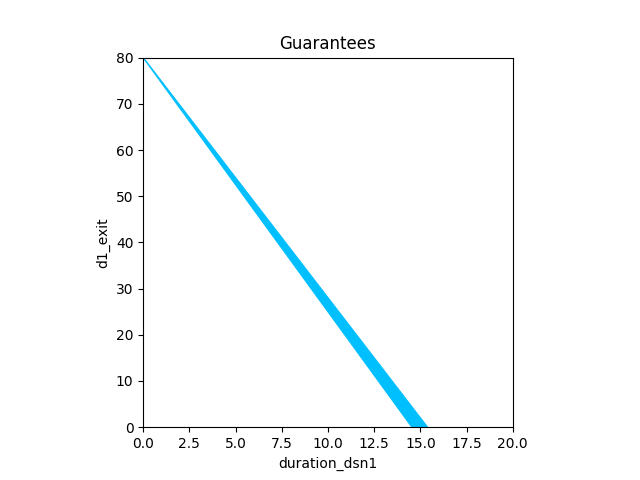

In [3]:
# - s: start index of the timeline variables
# - speed: (min, max) downlink rate during the task instance
def DSN_data(s: int, speed: tuple[float, float]) -> PolyhedralContract:
  spec = PolyhedralContract.from_string(
    input_vars = [
      f"d{s}_entry",        # initial data volume
      f"duration_dsn{s}",   # variable task duration
    ],
    output_vars = [
      f"d{s}_exit",          # final data volume
    ],
    assumptions = [
      # Task has a positive scheduled duration
      f"-duration_dsn{s} <= 0",

      # downlink data upper bound
      f" d{s}_entry <= 100",

      # downlink data lower bound
      f"-d{s}_entry <= 0",
    ],
    guarantees = [
      # duration*speed(min) <= d{entry} - d{exit} <= duration*speed(max)
      f" d{s}_entry - d{s}_exit - {speed[1]}*duration_dsn{s} <= 0",
      f"-d{s}_entry + d{s}_exit + {speed[0]}*duration_dsn{s} <= 0",

      # downlink cannot continue if there is no data left.
      f"-d{s}_exit <= 0",
    ])
  return spec

dsn1_science_storage = DSN_data(s=1, speed=(5.2, 5.5))
print(f"Contract dsn1_science_storage:\n\n{dsn1_science_storage}")

_ = plot_guarantees(contract=dsn1_science_storage,
                x_var=Var("duration_dsn1"),
                y_var=Var("d1_exit"),
                var_values={
                  Var("d1_entry"):80,
                },
                x_lims=(0,20),
                y_lims=(0,80))

In [4]:
dsn1_science_cumulative = nochange_contract(s=1, name="c")
print(f"dsn1_science_cumulative:\n\n{dsn1_science_cumulative}")

dsn1_science_cumulative:

InVars: [c1_entry]
OutVars:[c1_exit]
A: [
  
]
G: [
  -c1_entry + c1_exit = 0.0
]


In [5]:
dsn1_science = dsn1_science_storage.merge(dsn1_science_cumulative)
print(f"dsn1_science:\n\n{dsn1_science}")

dsn1_science:

InVars: [d1_entry, duration_dsn1, c1_entry]
OutVars:[d1_exit, c1_exit]
A: [
  -duration_dsn1 <= 0.0
  d1_entry <= 100.0
  -d1_entry <= 0.0
]
G: [
  d1_entry - d1_exit - 5.5 duration_dsn1 <= 0.0
  -d1_entry + d1_exit + 5.2 duration_dsn1 <= 0.0
  -d1_exit <= 0.0
  -c1_entry + c1_exit = 0.0
]


### SBO Task (Small body observations)

Objective: Acquire small body observations (science data & navigation)

As summarized in [the qualitative impacts table](#qualitative-impacts), this function affects this viewpoint with impacts that are linear with the duration of the task:
- the science data storage grows proportionally to a generation rate.
- the cumulative science data grows proportionally at the same rate.

Contract sbo1_science_storage:

InVars: [d3_entry, duration_sbo3]
OutVars:[d3_exit]
A: [
  -duration_sbo3 <= 0.0
  d3_entry + 4.0 duration_sbo3 <= 100.0
  -d3_entry <= 0.0
]
G: [
  -d3_entry + d3_exit - 4.0 duration_sbo3 <= 0.0
  d3_entry - d3_exit + 3.0 duration_sbo3 <= 0.0
]


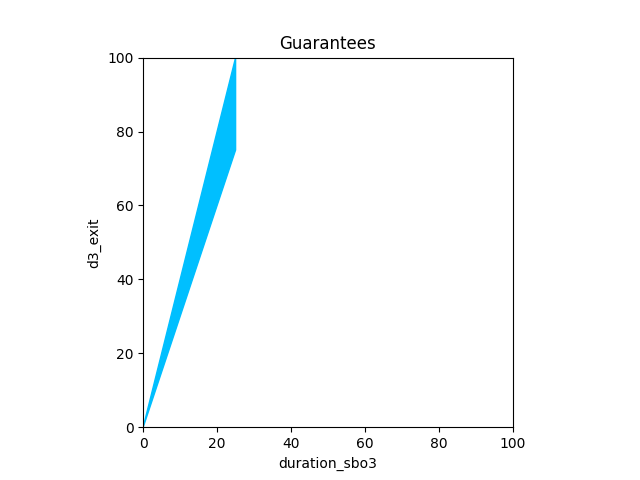

In [6]:
# Parameters:
# - s: start index of the timeline variables
# - generation: (min, max) rate of small body observations during the task instance
def SBO_science_storage(s: int, generation: tuple[float, float]) -> PolyhedralContract:
  spec = PolyhedralContract.from_string(
    input_vars = [
      f"d{s}_entry",        # initial data storage volume
      f"duration_sbo{s}",   # knob variable for SBO duration
    ],
    output_vars = [
      f"d{s}_exit",         # final data storage volume
    ],
    assumptions = [
      # Task has a positive scheduled duration
      f"-duration_sbo{s} <= 0",

      # There is enough data storage available
      f"d{s}_entry + {generation[1]}*duration_sbo{s} <= 100",

      # downlink data lower bound
      f"-d{s}_entry <= 0",
    ],
    guarantees = [
      # duration*generation(min) <= d{exit} - d{entry} <= duration*generation(max)
      f" d{s}_exit - d{s}_entry - {generation[1]}*duration_sbo{s} <= 0",
      f"-d{s}_exit + d{s}_entry + {generation[0]}*duration_sbo{s} <= 0",

      # Data volume cannot exceed the available storage capacity
      f"d{s}_exit <= 100",
    ])
  return spec

sbo1_science_storage = SBO_science_storage(s=3, generation=(3.0, 4.0))
print(f"Contract sbo1_science_storage:\n\n{sbo1_science_storage}")

_ = plot_guarantees(contract=sbo1_science_storage,
                x_var=Var("duration_sbo3"),
                y_var=Var("d3_exit"),
                var_values={
                  Var("d3_entry"):0,
                },
                x_lims=(0,100),
                y_lims=(0,100))

Contract sbo1_science_cumulative:

InVars: [c3_entry, duration_sbo3]
OutVars:[c3_exit]
A: [
  -duration_sbo3 <= 0.0
  -c3_entry <= 0.0
]
G: [
  -c3_entry + c3_exit - 4.0 duration_sbo3 <= 0.0
  c3_entry - c3_exit + 3.0 duration_sbo3 <= 0.0
]


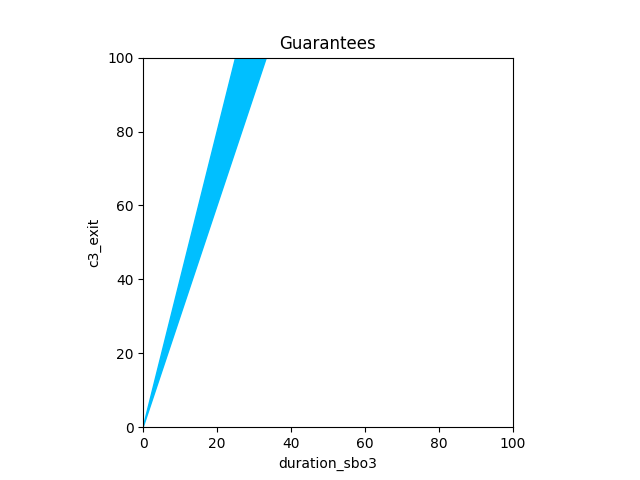

In [7]:
def SBO_science_comulative(s: int, generation: tuple[float, float]) -> PolyhedralContract:
  spec = PolyhedralContract.from_string(
    input_vars = [
      f"c{s}_entry",        # initial cumulative data volume
      f"duration_sbo{s}",   # knob variable for SBO duration
    ],
    output_vars = [
      f"c{s}_exit",         # final cumulative data volume
    ],
    assumptions = [
      # Task has a positive scheduled duration
      f"-duration_sbo{s} <= 0",

      # cumulative data lower bound
      f"-c{s}_entry <= 0",
    ],
    guarantees = [
      # duration*generation(min) <= c{exit} - c{entry} <= duration*generation(max)
      f" c{s}_exit - c{s}_entry - {generation[1]}*duration_sbo{s} <= 0",
      f"-c{s}_exit + c{s}_entry + {generation[0]}*duration_sbo{s} <= 0",
    ])
  return spec

sbo1_science_cumulative = SBO_science_comulative(s=3, generation=(3.0, 4.0))
print(f"Contract sbo1_science_cumulative:\n\n{sbo1_science_cumulative}")

_ = plot_guarantees(contract=sbo1_science_cumulative,
                x_var=Var("duration_sbo3"),
                y_var=Var("c3_exit"),
                var_values={
                  Var("c3_entry"):0,
                },
                x_lims=(0,100),
                y_lims=(0,100))

In [8]:
sbo1_science = sbo1_science_storage.merge(sbo1_science_cumulative)
print(f"Contract sbo1_science:\n\n{sbo1_science}")

Contract sbo1_science:

InVars: [d3_entry, duration_sbo3, c3_entry]
OutVars:[d3_exit, c3_exit]
A: [
  -duration_sbo3 <= 0.0
  d3_entry + 4.0 duration_sbo3 <= 100.0
  -d3_entry <= 0.0
  -c3_entry <= 0.0
]
G: [
  -d3_entry + d3_exit - 4.0 duration_sbo3 <= 0.0
  d3_entry - d3_exit + 3.0 duration_sbo3 <= 0.0
  -c3_entry + c3_exit - 4.0 duration_sbo3 <= 0.0
  c3_entry - c3_exit + 3.0 duration_sbo3 <= 0.0
]


### TCM Task (Perform a Trajectory Correction Maneuver)

Objective: Perform a delta-V maneuver to bring the spacecraft trajectory closer to that of the small body.

As described in [the qualitative impacts table](#qualitative-impacts), this function has no impact on science.

##### TCM Heating SubTask

Since TCM Heating has no impact on navigation, we use the no-change contract utility to specify this property for the two science viewpoint state variables: `d` and `c`.

In [9]:
tcm1_science_heating = nochange_contract(s=4, name="d").merge(nochange_contract(s=4, name="c"))
print(f"tcm1_science_heating:\n{tcm1_science_heating}")

tcm1_science_heating:
InVars: [d4_entry, c4_entry]
OutVars:[d4_exit, c4_exit]
A: [
  
]
G: [
  -d4_entry + d4_exit = 0.0
  -c4_entry + c4_exit = 0.0
]


##### TCM DeltaV SubTask

In [10]:
tcm1_science_deltav = nochange_contract(s=5, name="d").merge(nochange_contract(s=5, name="c"))
print(f"tcm1_science_deltav:\n{tcm1_science_deltav}")

tcm1_science_deltav:
InVars: [d5_entry, c5_entry]
OutVars:[d5_exit, c5_exit]
A: [
  
]
G: [
  -d5_entry + d5_exit = 0.0
  -c5_entry + c5_exit = 0.0
]


In [11]:
tcm1_science = scenario_sequence(c1=tcm1_science_heating, c2=tcm1_science_deltav, variables=["d", "c"], c1index=4)
print(f"tcm1_science:\n{tcm1_science}")

tcm1_science:
InVars: [d4_entry, c4_entry]
OutVars:[d5_exit, c5_exit, output_d4, output_c4]
A: [
  
]
G: [
  -d4_entry + output_d4 = 0.0
  -c4_entry + output_c4 = 0.0
  d5_exit - output_d4 = 0.0
  c5_exit - output_c4 = 0.0
]


### science & Communication Schedule Analysis

Let's consider a simple 4-step schedule of the following sequence of task instances, which we compose:
- DSN
- CHARGING
- SBO
- TCM

In [12]:
print(dsn1_science)

InVars: [d1_entry, duration_dsn1, c1_entry]
OutVars:[d1_exit, c1_exit]
A: [
  -duration_dsn1 <= 0.0
  d1_entry <= 100.0
  -d1_entry <= 0.0
]
G: [
  d1_entry - d1_exit - 5.5 duration_dsn1 <= 0.0
  -d1_entry + d1_exit + 5.2 duration_dsn1 <= 0.0
  -d1_exit <= 0.0
  -c1_entry + c1_exit = 0.0
]


In [13]:
steps12=scenario_sequence(c1=dsn1_science, c2=charging1_science, variables=["d", "c"], c1index=1)
print(f"---- Steps 1,2\n{steps12}")
print(steps12.get_variable_bounds("output_d1"))
print(steps12.get_variable_bounds("output_c1"))

---- Steps 1,2
InVars: [d1_entry, duration_dsn1, c1_entry]
OutVars:[d2_exit, c2_exit, output_d1, output_c1]
A: [
  -duration_dsn1 <= 0.0
  d1_entry <= 100.0
  -d1_entry <= 0.0
]
G: [
  d1_entry - 5.5 duration_dsn1 - output_d1 <= 0.0
  -d1_entry + 5.2 duration_dsn1 + output_d1 <= 0.0
  -output_d1 <= 0.0
  -c1_entry + output_c1 = 0.0
  d2_exit - output_d1 = 0.0
  c2_exit - output_c1 = 0.0
]
(0.0, 100.0)
(None, None)


In [14]:
steps123=scenario_sequence(c1=steps12, c2=sbo1_science, variables=["d", "c"], c1index=2)
print(f"---- Steps 1,2,3\n{steps123}")
print(steps123.get_variable_bounds("output_d2"))
print(steps123.get_variable_bounds("output_c2"))
print(steps123.get_variable_bounds("duration_sbo3"))

---- Steps 1,2,3
InVars: [d1_entry, duration_dsn1, c1_entry, duration_sbo3]
OutVars:[output_d1, output_c1, d3_exit, c3_exit, output_d2, output_c2]
A: [
  -duration_sbo3 <= 0.0
  -duration_dsn1 <= 0.0
  d1_entry <= 100.0
  -d1_entry <= 0.0
]
G: [
  d1_entry - 5.5 duration_dsn1 - output_d1 <= 0.0
  -d1_entry + 5.2 duration_dsn1 + output_d1 <= 0.0
  -output_d1 <= 0.0
  -c1_entry + output_c1 = 0.0
  -output_d1 + output_d2 = 0.0
  -output_c1 + output_c2 = 0.0
  d3_exit - 4.0 duration_sbo3 - output_d2 <= 0.0
  -d3_exit + 3.0 duration_sbo3 + output_d2 <= 0.0
  c3_exit - 4.0 duration_sbo3 - output_c2 <= 0.0
  -c3_exit + 3.0 duration_sbo3 + output_c2 <= 0.0
]
(0.0, 100.0)
(None, None)
(0.0, None)


In [15]:
steps1234=scenario_sequence(c1=steps123, c2=tcm1_science, variables=["d", "c"], c1index=3)
print(f"---- Steps 1,2,3,4\n{steps1234}")
print(steps1234.get_variable_bounds("output_d3"))
print(steps1234.get_variable_bounds("output_c3"))

---- Steps 1,2,3,4
InVars: [d1_entry, duration_dsn1, c1_entry, duration_sbo3]
OutVars:[output_d1, output_c1, output_d2, output_c2, d5_exit, c5_exit, output_d4, output_c4, output_d3, output_c3]
A: [
  -duration_sbo3 <= 0.0
  -duration_dsn1 <= 0.0
  d1_entry <= 100.0
  -d1_entry <= 0.0
]
G: [
  d1_entry - 5.5 duration_dsn1 - output_d1 <= 0.0
  -d1_entry + 5.2 duration_dsn1 + output_d1 <= 0.0
  -output_d1 <= 0.0
  -c1_entry + output_c1 = 0.0
  -output_d1 + output_d2 = 0.0
  -output_c1 + output_c2 = 0.0
  -4.0 duration_sbo3 - output_d2 + output_d3 <= 0.0
  3.0 duration_sbo3 + output_d2 - output_d3 <= 0.0
  -4.0 duration_sbo3 - output_c2 + output_c3 <= 0.0
  3.0 duration_sbo3 + output_c2 - output_c3 <= 0.0
  -output_d3 + output_d4 = 0.0
  -output_c3 + output_c4 = 0.0
  d5_exit - output_d4 = 0.0
  c5_exit - output_c4 = 0.0
]
(0.0, None)
(None, None)


In [16]:
scenario_science=steps1234.rename_variables([
    ("d4_exit", "output_d4"), 
    ("c4_exit", "output_c4"),
    ("d5_exit", "output_d5"), 
    ("c5_exit", "output_c5")])
print(f"scenario_science={scenario_science}")

scenario_science=InVars: [d1_entry, duration_dsn1, c1_entry, duration_sbo3]
OutVars:[output_d1, output_c1, output_d2, output_c2, output_d4, output_c4, output_d3, output_c3, output_d5, output_c5]
A: [
  -duration_sbo3 <= 0.0
  -duration_dsn1 <= 0.0
  d1_entry <= 100.0
  -d1_entry <= 0.0
]
G: [
  d1_entry - 5.5 duration_dsn1 - output_d1 <= 0.0
  -d1_entry + 5.2 duration_dsn1 + output_d1 <= 0.0
  -output_d1 <= 0.0
  -c1_entry + output_c1 = 0.0
  -output_d1 + output_d2 = 0.0
  -output_c1 + output_c2 = 0.0
  -4.0 duration_sbo3 - output_d2 + output_d3 <= 0.0
  3.0 duration_sbo3 + output_d2 - output_d3 <= 0.0
  -4.0 duration_sbo3 - output_c2 + output_c3 <= 0.0
  3.0 duration_sbo3 + output_c2 - output_c3 <= 0.0
  -output_d3 + output_d4 = 0.0
  -output_c3 + output_c4 = 0.0
  -output_d4 + output_d5 = 0.0
  -output_c4 + output_c5 = 0.0
]


In [17]:
write_contracts_to_file(contracts=[scenario_science], names=["scenario_science"], file_name="json/scenario_science.json")